# Predict volume from LiDAR features

In [1]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.callback.progress import ShowGraphCallback

/home/mayrajeo/miniconda3/envs/enveco/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.tabular.preprocessing import *
from enveco.interpretation import *
from enveco.model.ensemble import *
from enveco.metrics import *

Run the example workflow for predicting the volume of the field plot from LiDAR-derived features.

# Read and preprocess data

In [3]:
#data_path = Path('../../../andras/ml/AV_leafon/')
data_path = Path('../../enveco_data/enveco/')
tif_features = data_path/'raster_features.csv'
preprocessor = EnvecoPreprocessor(data_path/'AV.leaf.on.train.csv', 
                                  data_path/'AV.leaf.on.val.csv',
                                  data_path/'AV.leaf.on.test.csv')

Preprocess dataframes and extract lidar features from them. Specify which features are needed:

* height_features
* point_features
* intensity_features
* height_quantiles
* point_proportions
* canopy_densities

Also, specify whether to `normalize` data (default: True) or to log-transform target column (default: False)

In [4]:
def tree_pcts(row):
    return [row.v_ma/row.v, row.v_ku/row.v, row.v_lp/row.v]

In [5]:
preprocessor.train_val_df[['rel_v_ma', 'rel_v_ku', 'rel_v_lp']] = preprocessor.train_val_df.apply(lambda row: tree_pcts(row), 
                                                                                                  axis=1, result_type='expand')

In [6]:
preprocessor.test_df[['rel_v_ma', 'rel_v_ku', 'rel_v_lp']] = preprocessor.test_df.apply(lambda row: tree_pcts(row), 
                                                                                                  axis=1, result_type='expand')

In [7]:
preprocessor.train_val_df.head()

,sampleplotid,x,y,measurementdate,g,d,h,v,v_ma,v_ku,...,a_date_1,a_window_1,filename_2,a_date_2,a_window_2,v_lp_proc,is_valid,rel_v_ma,rel_v_ku,rel_v_lp
0,901034,313598.50,6888193.46,2013,30.0,25.9,23.9,336.62,50.11,27.73,...,2013-07-11,C,NaN,NaN,NaN,77,0,0.148862,0.082378,0.768760
1,901038,314591.78,6888461.84,2013,18.6,16.0,15.9,146.00,142.50,0.00,...,2013-07-11,C,NaN,NaN,NaN,2,0,0.976027,0.000000,0.023973
2,901044,317890.37,6888182.49,2013,26.8,18.4,18.4,240.46,139.89,81.77,...,2013-07-11,C,NaN,NaN,NaN,8,0,0.581760,0.340057,0.078142
3,901048,318879.42,6888447.55,2013,34.3,20.2,19.3,321.29,72.10,172.35,...,2013-07-11,C,NaN,NaN,NaN,24,0,0.224408,0.536431,0.239161
4,901054,322193.41,6888196.04,2013,13.8,10.0,9.1,67.10,57.40,9.70,...,2013-07-11,C,NaN,NaN,NaN,0,0,0.855440,0.144560,0.000000


In [8]:
trainval_tb, test_tb = preprocessor.preprocess_image(target_col=['v'], 
                                                     path=data_path/'AV_tif',
                                                     normalize=True,
                                                     log_y=False)

  3%|▎         | 32/1269 [00:02<01:49, 11.31it/s]


KeyboardInterrupt: 

In [9]:
trainval_tb, test_tb = preprocessor.preprocess(target_col=['v'], 
                                               path=data_path,
                                               lidar_pref='AV_las',
                                               image_pref='AV_tif',
                                               mask_plot=False,
                                               min_h=1.3,
                                               normalize=True,
                                               log_y=False,
                                               save_path='../../enveco_data')

100%|██████████| 225/225 [00:20<00:00, 11.00it/s]


Previous method returns two `TabularPandas` objects. Put them to dataloaders.

In [78]:
trainval_tb, test_tb = preprocessor.load_las_image(path='../../enveco_data', target_col=['v'])

In [79]:
dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock)

Check the distribution of the target variable `v`, in order to get limits for `sigmoid_range`.

In [80]:
trainval_tb.train.y.describe()

count    1044.000000
mean      145.712250
std        86.097336
min         2.700000
25%        80.927498
50%       132.125000
75%       191.305000
max       867.349976
Name: v, dtype: float64

In [81]:
trainval_tb.valid.y.describe()

count    225.000000
mean     150.768631
std       95.610825
min        2.310000
25%       87.419998
50%      133.600006
75%      191.639999
max      539.479980
Name: v, dtype: float64

In [82]:
test_tb.train.y.describe()

count    225.000000
mean     152.013641
std       97.223846
min        7.000000
25%       87.820000
50%      134.979996
75%      192.529999
max      550.169983
Name: v, dtype: float64

# ANN

Create `Learner` object. Specify y_range to better control the training, set 1000 m³ as the maximum value for the total volume.

Loss function is Mean Squared Error, monitor also Root Mean Squared Error, mean-normalized RMSE, Mean Absolute Error, R2Score, bias and mean-scaled bias. Target variable is log-transformed, so all metrics are log-equivalents (so MSLE, RMSLE...).

In [83]:
learn = tabular_learner(dls, 
                        metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  
                        y_range=(0, trainval_tb.train.y.max()*1.1)
                       )
learn.summary()

TabularModel (Input shape: 64 x torch.Size([64, 147]))
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 147            
BatchNorm1d                               294        True      
BatchNorm1d                               294        True      
____________________________________________________________________________
                     64 x 200            
Linear                                    29400      True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     64 x 100            
Linear                                    20000      True      
ReLU                                                           
____________________________________________________________________________
                     64 x 1              
Linear                            

Find learning rate to use.

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.001737800776027143)

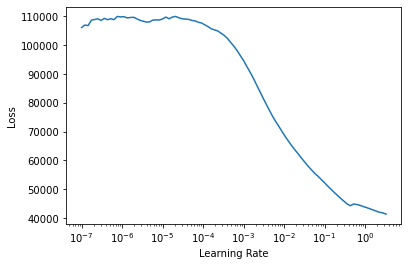

In [84]:
learn.lr_find()

1e-2 seems to be a good learning rate.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,56676.488281,38991.226562,197.461960,130.970200,180.503525,119.722206,184.971664,-3.284373,00:00
1,28982.990234,5159.615723,71.830467,47.642853,5.277515,3.500407,50.579792,0.433059,00:00
2,17753.330078,4536.921387,67.356667,44.675522,-11.017723,-7.307703,50.385777,0.501481,00:00
3,12364.243164,3404.266846,58.346092,38.699097,-15.380880,-10.201646,42.469414,0.625938,00:00
4,8926.274414,2655.047119,51.527153,34.176311,4.032747,2.674792,35.680973,0.708262,00:00
5,6653.248047,2030.988647,45.066490,29.891161,1.184703,0.785776,32.778248,0.776834,00:00
6,5107.262207,2536.363037,50.362316,33.403713,2.378330,1.577470,32.576496,0.721303,00:00
7,3988.264404,2029.927246,45.054714,29.883352,-6.269875,-4.158607,30.778534,0.776951,00:00
8,3238.895996,2536.450439,50.363190,33.404293,17.761402,11.780570,34.585331,0.721294,00:00
9,2809.391846,2605.621094,51.045284,33.856705,12.053544,7.994730,35.035057,0.713693,00:00


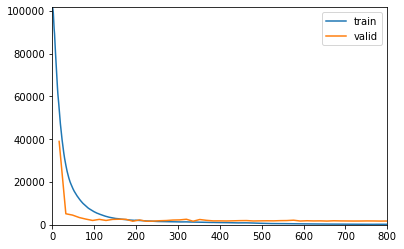

In [85]:
learn.fit_one_cycle(50, lr_max=1e-2, cbs=ShowGraphCallback())

See validation results

In [86]:
learn.validate()

(#7) [1769.1893310546875,42.06173324584961,27.89820098876953,1.9691047668457031,1.3060442209243774,28.372201919555664,0.8056007192813236]

In [87]:
preds, true = learn.get_preds()

`RegressionInterpretation` can be used to plot results.

In [88]:
reg_interp = RegressionInterpretation.from_learner(learn)

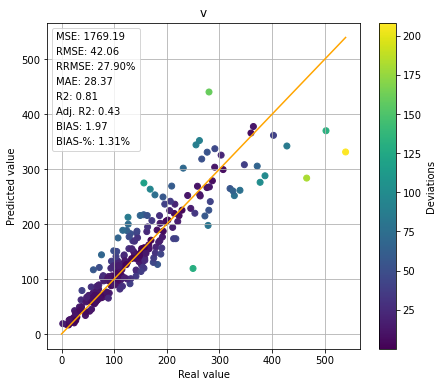

In [89]:
reg_interp.plot_results(log_y=False)
plt.show()

Evaluate test set.

In [90]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)

In [91]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dls.train, ds_idx=0)

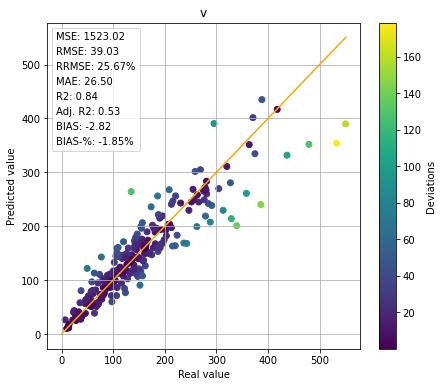

In [92]:
test_interp.plot_results(log_y=False)
plt.show()

In [36]:
test_preds = learn.get_preds(dl=test_dls.train)

# Ensemble of ANNs

Fit several models at once.

In [93]:
ensemble = Ensemble(dls, learn_func=tabular_learner, ens_dir='ensembles',
                    y_range=(0,trainval_tb.y.max() * 1.1), 
                    metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()], 
                    n_models=10)

In [94]:
ensemble.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,27054.873047,14697.208984,121.232048,80.409340,95.425377,63.292603,107.839706,-0.614936,00:00
1,14290.373047,5524.770996,74.328819,49.299927,-5.893770,-3.909149,54.896896,0.392936,00:00
2,9453.957031,3461.098389,58.831100,39.020786,-5.758694,-3.819557,38.176598,0.619693,00:00
3,6868.430664,3881.278320,62.299908,41.321537,16.908701,11.215000,46.104206,0.573523,00:00
4,5185.640137,2207.781982,46.987041,31.165001,-14.415241,-9.561169,33.226646,0.757408,00:00
5,4226.180664,2668.794922,51.660381,34.264679,-8.515568,-5.648104,34.878803,0.706752,00:00
6,3603.638428,2447.344727,49.470642,32.812294,-9.859952,-6.539791,37.290886,0.731085,00:00
7,3044.187744,2558.682861,50.583424,33.550365,21.101324,13.995832,36.706032,0.718851,00:00
8,2577.275146,2006.655884,44.795712,29.711563,-6.292413,-4.173556,31.323462,0.779508,00:00
9,2156.211182,1820.293945,42.664902,28.298265,3.489430,2.314427,30.759251,0.799985,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,45969.578125,23225.001953,152.397507,101.080391,127.146980,84.332527,137.163818,-1.551973,00:00
1,22295.027344,7794.012207,88.283707,58.555759,-6.755418,-4.480653,61.448429,0.143591,00:00
2,14501.216797,6912.826172,83.143410,55.146366,-13.599170,-9.019895,59.757862,0.240416,00:00
3,10295.940430,3828.851318,61.877712,41.041508,-25.543892,-16.942446,45.315388,0.579284,00:00
4,7694.204102,3798.515869,61.632099,40.878601,15.999349,10.611856,43.760529,0.582617,00:00
5,5908.980469,2667.726562,51.650040,34.257820,14.607079,9.688408,36.612293,0.706869,00:00
6,4667.864746,2365.193115,48.633251,32.256882,-13.972124,-9.267262,34.025742,0.740112,00:00
7,3745.624756,2299.603760,47.954182,31.806475,14.683756,9.739265,33.518597,0.747319,00:00
8,3056.969971,2174.378906,46.630238,30.928343,-7.049586,-4.675765,32.484550,0.761078,00:00
9,2557.104248,1798.484131,42.408539,28.128227,11.600478,7.694226,30.228481,0.802382,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,74989.789062,37204.753906,192.885345,127.934685,172.742935,114.574860,177.758057,-3.088074,00:00
1,36023.136719,8495.040039,92.168541,61.132442,7.068043,4.688006,66.202698,0.066561,00:00
2,22563.462891,5619.648438,74.964317,49.721436,6.588355,4.369845,58.224735,0.382511,00:00
3,15246.228516,2492.206299,49.922001,33.111668,6.670570,4.424376,34.689362,0.726155,00:00
4,10896.637695,4682.587402,68.429436,45.387058,-33.952835,-22.519829,48.744411,0.485475,00:00
5,8051.414062,3721.481445,61.003948,40.461967,-24.122293,-15.999545,43.730621,0.591082,00:00
6,6083.139160,2055.019775,45.332325,30.067480,16.759487,11.116032,32.219414,0.774194,00:00
7,4690.708008,1872.756836,43.275356,28.703159,14.094814,9.348639,31.769230,0.794221,00:00
8,3690.433838,1687.025635,41.073418,27.242683,12.657606,8.395386,28.630777,0.814629,00:00
9,2982.748291,2187.995605,46.776016,31.025034,11.148344,7.394340,32.652054,0.759582,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,77485.171875,34675.429688,186.213394,123.509384,157.513885,104.473923,170.243530,-2.810151,00:00
1,36882.390625,7617.408203,87.277763,57.888550,-8.609968,-5.710717,63.003052,0.162996,00:00
2,23014.574219,4429.577637,66.555069,44.143848,-15.637775,-10.372037,51.895412,0.513276,00:00
3,15422.458984,3478.833008,58.981632,39.120628,-8.448871,-5.603866,41.232098,0.617744,00:00
4,11162.268555,4856.722168,69.690193,46.223278,-32.636444,-21.646709,46.314583,0.466341,00:00
5,8256.402344,2061.469727,45.403408,30.114628,7.921542,5.254105,32.303223,0.773485,00:00
6,6218.138184,2738.173828,52.327560,34.707199,-13.333423,-8.843633,35.141525,0.699128,00:00
7,4774.619141,2276.906738,47.716942,31.649122,17.716455,11.750758,33.188198,0.749813,00:00
8,3750.593750,1851.921753,43.033962,28.543049,7.541111,5.001778,29.343596,0.796510,00:00
9,2997.029297,1835.086670,42.837910,28.413015,0.783981,0.519990,28.743980,0.798360,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,76263.093750,37542.558594,193.759018,128.514160,169.151337,112.192665,178.434174,-3.125192,00:00
1,36270.761719,14765.029297,121.511421,80.594643,6.211422,4.119838,82.482536,-0.622388,00:00
2,22671.175781,4849.729004,69.639999,46.189983,-23.718819,-15.731934,51.678593,0.467110,00:00
3,15298.145508,4339.267578,65.873116,43.691532,12.174149,8.074723,45.072842,0.523199,00:00
4,10805.699219,2464.701416,49.645756,32.928444,-7.958625,-5.278701,35.056213,0.729178,00:00
5,7812.008789,2466.238037,49.661236,32.938709,-11.421182,-7.575305,35.234898,0.729009,00:00
6,5914.473145,2035.745117,45.119232,29.926142,9.323386,6.183904,32.664536,0.776311,00:00
7,4603.332031,2771.156982,52.641781,34.915607,20.156900,13.369428,36.230541,0.695504,00:00
8,3674.179688,2102.629639,45.854439,30.413782,14.875834,9.866666,31.734297,0.768962,00:00
9,2946.474121,1501.373169,38.747559,25.700014,7.400958,4.908818,27.256878,0.835028,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,40681.164062,19858.205078,140.919144,93.467155,112.714447,74.759888,125.351639,-1.182028,00:00
1,19755.890625,4495.848633,67.051094,44.472847,-27.354649,-18.143463,52.851971,0.505994,00:00
2,12840.910156,4714.401855,68.661499,45.540977,19.458403,12.906136,51.217495,0.481980,00:00
3,8863.277344,2962.781738,54.431442,36.102634,3.169914,2.102502,34.032272,0.674448,00:00
4,6664.436035,2763.513916,52.569134,34.867424,-13.899217,-9.218905,35.878345,0.696344,00:00
5,5097.087402,2755.120117,52.489235,34.814430,-9.605577,-6.371072,37.255505,0.697266,00:00
6,3959.367188,2313.790771,48.101879,31.904438,7.583192,5.029689,32.419048,0.745760,00:00
7,3173.371582,1985.528931,44.559273,29.554739,2.209062,1.465200,29.569288,0.781829,00:00
8,2588.483643,1750.144897,41.834736,27.747643,0.253886,0.168394,29.416346,0.807693,00:00
9,2254.905029,2012.998413,44.866451,29.758484,-3.065456,-2.033219,30.268618,0.778811,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,51753.484375,22884.466797,151.276123,100.336609,126.707474,84.041016,136.427155,-1.514555,00:00
1,25143.556641,8495.021484,92.168434,61.132370,0.209657,0.139059,66.689606,0.066563,00:00
2,16055.700195,4204.281738,64.840431,43.006584,-3.543830,-2.350509,48.760723,0.538032,00:00
3,10959.968750,3732.578613,61.094830,40.522247,-21.071999,-13.976383,40.508183,0.589863,00:00
4,8180.798828,4862.140625,69.729050,46.249046,-25.770409,-17.092688,43.896580,0.465746,00:00
5,6112.026367,1955.874756,44.225273,29.333210,-6.147326,-4.077325,31.787943,0.785088,00:00
6,4704.104980,1872.719116,43.274925,28.702873,-8.289369,-5.498073,28.951210,0.794225,00:00
7,3729.011719,2107.383057,45.906242,30.448141,-2.509305,-1.664341,32.425705,0.768440,00:00
8,3148.306641,1675.602051,40.934120,27.150291,1.711911,1.135456,30.561499,0.815884,00:00
9,2617.994629,1790.524536,42.314590,28.065914,13.267884,8.800163,30.969254,0.803256,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,52485.007812,27558.453125,166.007401,110.107399,136.320236,90.416847,151.286575,-2.028135,00:00
1,25436.564453,8405.809570,91.683205,60.810535,10.817679,7.175021,68.143723,0.076366,00:00
2,16227.823242,6897.903809,83.053619,55.086811,-29.978033,-19.883471,54.383808,0.242055,00:00
3,11355.716797,2464.053223,49.639229,32.924114,-15.264473,-10.124436,35.400024,0.729249,00:00
4,8226.853516,3827.174561,61.864155,41.032513,13.966346,9.263430,41.449020,0.579468,00:00
5,6454.884766,2677.261230,51.742256,34.318985,12.588656,8.349653,35.945164,0.705821,00:00
6,5119.051758,2098.329834,45.807529,30.382669,13.270526,8.801915,31.587084,0.769435,00:00
7,4015.483398,1755.449585,41.898087,27.789661,2.964473,1.966241,28.394196,0.807110,00:00
8,3250.654297,1893.790527,43.517704,28.863901,0.076137,0.050499,30.455818,0.791909,00:00
9,2650.276611,1928.897095,43.919209,29.130205,12.997062,8.620535,29.714201,0.788052,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,101597.335938,44546.828125,211.061188,139.990143,190.035583,126.044525,196.067459,-3.894824,00:00
1,48389.277344,10256.904297,101.276382,67.173386,-11.882562,-7.881323,72.264717,-0.127033,00:00
2,29778.089844,3917.455811,62.589577,41.513664,-8.208302,-5.444304,51.759510,0.569548,00:00
3,19683.505859,3444.421875,58.689194,38.926662,8.594408,5.700396,40.286758,0.621525,00:00
4,13569.198242,1772.001099,42.095142,27.920362,10.458035,6.936480,30.231623,0.805292,00:00
5,9873.113281,2541.043945,50.408772,33.434525,-15.985278,-10.602524,34.909725,0.720789,00:00
6,7325.557617,2151.500488,46.384266,30.765200,15.462380,10.255702,32.428719,0.763592,00:00
7,5577.133789,1883.096558,43.394661,28.782290,1.025016,0.679860,30.848139,0.793085,00:00
8,4409.121582,3972.832764,63.030411,41.806053,-21.875017,-14.508999,41.101494,0.563463,00:00
9,3664.152344,2084.057861,45.651482,30.279169,-13.277038,-8.806234,31.088282,0.771003,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,46586.980469,22257.966797,149.191040,98.953644,120.547890,79.955559,134.511749,-1.445715,00:00
1,22437.691406,7672.846680,87.594788,58.098824,-2.542145,-1.686123,62.749084,0.156904,00:00
2,14256.219727,3481.314453,59.002666,39.134579,-8.441847,-5.599207,46.138412,0.617472,00:00
3,9790.264648,1913.822754,43.747261,29.016157,1.653073,1.096430,30.589323,0.789708,00:00
4,7105.600586,2096.823975,45.791092,30.371767,-8.826940,-5.854627,33.268661,0.769600,00:00
5,5386.017090,1613.204956,40.164722,26.639975,3.661095,2.428287,29.043877,0.822740,00:00
6,4415.910645,2768.347168,52.615086,34.897903,-18.264322,-12.114141,35.560246,0.695813,00:00
7,3677.384033,1888.387451,43.455585,28.822699,19.193899,12.730700,32.117302,0.792503,00:00
8,2966.055420,2013.910034,44.876610,29.765219,-6.540667,-4.338215,29.384678,0.778711,00:00
9,2515.436035,1640.428833,40.502209,26.863819,-13.379663,-8.874303,29.211405,0.819749,00:00


In [95]:
res = ensemble.validate()

See ensemble validation results.

In [96]:
res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,36.801189,24.409052,3.535553,2.345019,24.971743,0.851186
1,0.0,39.317097,26.077770,5.022175,3.331048,26.727827,0.830143
2,1.0,37.399803,24.806093,2.771669,1.838359,25.600622,0.846305
3,2.0,38.300014,25.403175,2.802372,1.858724,25.969896,0.838817
4,3.0,38.014256,25.213640,3.516310,2.332256,26.559525,0.841214
5,4.0,38.322460,25.418060,2.175545,1.442969,26.392387,0.838628
6,5.0,41.426762,27.477047,2.905169,1.926906,26.567661,0.811426
7,6.0,39.853603,26.433620,4.581067,3.038475,26.627865,0.825476
8,7.0,39.162834,25.975454,4.931915,3.271181,26.357050,0.831473
9,8.0,36.575710,24.259499,2.662383,1.765874,25.977953,0.853004


In [97]:
ens_int = RegressionInterpretation.from_ensemble(ensemble)

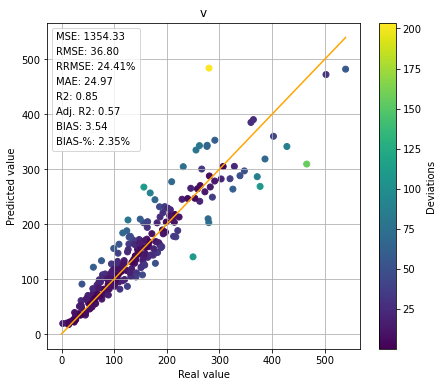

In [98]:
ens_int.plot_results(log_y=False)
plt.show()

Run test set predictions.

In [99]:
test_res = ensemble.validate(dl=test_dls[0])
test_res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,35.696049,23.482136,-1.368399,-0.900182,23.804319,0.864597
1,0.0,37.885517,24.922445,-2.449764,-1.611543,25.189280,0.847477
2,1.0,38.191238,25.123560,-1.997803,-1.314226,25.621288,0.845005
3,2.0,39.812225,26.189903,-1.465804,-0.964258,26.465490,0.831569
4,3.0,36.893906,24.270128,-0.200486,-0.131887,25.719124,0.855357
5,4.0,37.591957,24.729330,-1.480720,-0.974070,25.531836,0.849832
6,5.0,37.239071,24.497190,-2.167580,-1.425911,24.988869,0.852638
7,6.0,35.085518,23.080507,-1.936467,-1.273877,23.319578,0.869189
8,7.0,36.723721,24.158175,0.662868,0.436058,24.851225,0.856688
9,8.0,38.472816,25.308790,-2.772954,-1.824148,25.682747,0.842712


In [100]:
test_ens_interp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])

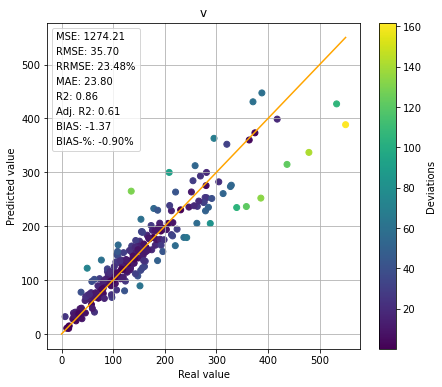

In [101]:
test_ens_interp.plot_results(log_y=False)
plt.show()

In [46]:
ensemble.export(folder='ensemble_h_noint')

In [34]:
loaded_ens = load_ensemble('ensemble')

In [35]:
loaded_ens.validate(dls[1])

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,34.512131,22.890789,4.853094,3.218901,23.012722,0.869123
1,0,36.020157,23.891016,5.776916,3.831643,24.523306,0.857435
2,1,38.956333,25.838488,5.520294,3.661434,26.004436,0.833246
3,2,37.076843,24.591881,5.411808,3.589478,23.871897,0.848948
4,3,36.172024,23.991745,5.350533,3.548837,24.588570,0.856231
5,4,35.007332,23.219242,3.500980,2.322088,24.198902,0.865340
6,5,36.793751,24.404116,4.694864,3.113953,24.732487,0.851246
7,6,38.035831,25.227949,5.096254,3.380182,26.099972,0.841033
8,7,36.272240,24.058214,2.586123,1.715292,24.851715,0.855433
9,8,37.683136,24.994015,6.113510,4.054895,25.995430,0.843968


# Comparison: Random forest

`TabularPandas` makes it simple to use sklearn models with the same data and preprocessing.

In [47]:
from sklearn.ensemble import RandomForestRegressor

Below values for max_features and min_samples_leaf should generally work well.

In [48]:
rf = RandomForestRegressor(n_estimators=500, max_features=0.5, min_samples_leaf=4, oob_score=True)

In [49]:
rf.fit(trainval_tb.train.xs, trainval_tb.train.ys.values.ravel())

RandomForestRegressor(max_features=0.5, min_samples_leaf=4, n_estimators=500,
                      oob_score=True)

In [50]:
rf_preds = rf.predict(trainval_tb.valid.xs)

Validation results

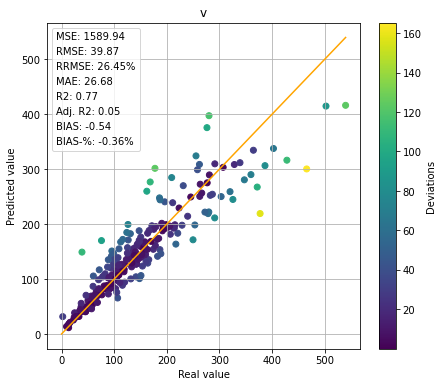

In [51]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys, log_y=False)
plt.show()

Test results

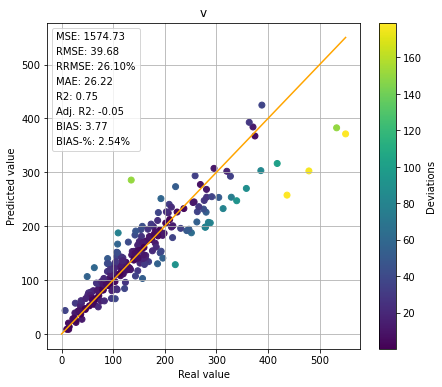

In [52]:
rf_test_preds = rf.predict(test_tb.train.xs)
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys)
plt.show()